# Dog Length-of-Stay (LOS) Prediction Pipeline
## Champaign Animal Shelter Data Analysis 

This notebook contains an MLP model with comprehensive feature engineering.
Features include age, breed characteristics, temporal patterns, and additional relevant indicators for length of stay prediction.


## 1. Environment Setup


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import re
import random
from typing import Dict, List
warnings.filterwarnings('ignore')

# Deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix)
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA

# Hyperparameter tuning
try:
    import optuna
    OPTUNA_AVAILABLE = True
except ImportError:
    OPTUNA_AVAILABLE = False
    print("Warning: Optuna not available. Install with: pip install optuna")

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
random.seed(RANDOM_SEED)

# Create output directories
os.makedirs('plots', exist_ok=True)
os.makedirs('models', exist_ok=True)


## 2. Feature Engineering


In [2]:
# Focus on: Age, Intake Type, Breed, temporal patterns, and additional relevant features

def get_age_group(age_group_str):
    """Extract age group from Age Group at Intake column"""
    if pd.isna(age_group_str):
        return "unknown"
    age_str = str(age_group_str).upper()
    if "PUPPY" in age_str or "YOUNG" in age_str:
        return "puppy"
    elif "SENIOR" in age_str or "GERIATRIC" in age_str:
        return "senior"
    else:
        return "adult"

def get_breed_size_simple(breed_str):
    """Simple breed size categorization"""
    if pd.isna(breed_str):
        return "unknown"
    breed_upper = str(breed_str).upper()
    # Check for size indicators
    if any(word in breed_upper for word in ["GIANT", "GREAT DANE", "MASTIFF", "ST BERNARD", "NEWFOUNDLAND"]):
        return "giant"
    elif any(word in breed_upper for word in ["TOY", "MINIATURE", "MINI ", "CHIHUAHUA", "POMERANIAN", "YORKIE"]):
        return "small"
    elif any(word in breed_upper for word in ["LABRADOR", "GOLDEN", "RETRIEVER", "SHEPHERD", "ROTTWEILER", "HUSKY"]):
        return "large"
    else:
        return "medium"

def calculate_age_days(date_of_birth, intake_date):
    """Calculate age in days at intake"""
    if pd.isna(date_of_birth) or pd.isna(intake_date):
        return None
    try:
        dob = pd.to_datetime(date_of_birth, errors='coerce')
        if pd.isna(dob):
            return None
        age_days = (intake_date - dob).days
        return max(0, age_days) if age_days >= 0 else None
    except:
        return None

def get_season(month):
    """Get season from month (1-12)"""
    if pd.isna(month):
        return "unknown"
    month = int(month)
    if month in [12, 1, 2]:
        return "winter"
    elif month in [3, 4, 5]:
        return "spring"
    elif month in [6, 7, 8]:
        return "summer"
    else:  # 9, 10, 11
        return "fall"

def get_quarter(month):
    """Get quarter from month (1-12)"""
    if pd.isna(month):
        return "unknown"
    month = int(month)
    if month in [1, 2, 3]:
        return "Q1"
    elif month in [4, 5, 6]:
        return "Q2"
    elif month in [7, 8, 9]:
        return "Q3"
    else:  # 10, 11, 12
        return "Q4"

def is_weekend(weekday):
    """Check if weekday is weekend (Saturday=5, Sunday=6)"""
    if pd.isna(weekday):
        return 0
    return 1 if weekday >= 5 else 0

def is_holiday(date):
    """Check if date is a major US holiday (simplified)"""
    if pd.isna(date):
        return 0
    try:
        month = date.month
        day = date.day
        
        # New Year's Day
        if month == 1 and day == 1:
            return 1
        # Independence Day
        if month == 7 and day == 4:
            return 1
        # Christmas
        if month == 12 and day == 25:
            return 1
        # Thanksgiving (4th Thursday in November - simplified to Nov 24-28)
        if month == 11 and 24 <= day <= 28:
            return 1
        # Memorial Day (last Monday in May - simplified to May 25-31)
        if month == 5 and 25 <= day <= 31:
            return 1
        # Labor Day (first Monday in September - simplified to Sep 1-7)
        if month == 9 and 1 <= day <= 7:
            return 1
        
        return 0
    except:
        return 0

def is_mixed_breed(primary_breed, secondary_breed):
    """Check if dog is a mixed breed"""
    if pd.isna(primary_breed):
        return 0
    primary_upper = str(primary_breed).upper()
    # Check if primary breed contains "mix" or "mixed"
    if "MIX" in primary_upper:
        return 1
    # Check if secondary breed exists and is not empty
    if not pd.isna(secondary_breed) and str(secondary_breed).strip().upper() not in ["", "UNKNOWN", "NONE"]:
        return 1
    return 0

def has_name(animal_name):
    """Check if animal has a name"""
    if pd.isna(animal_name):
        return 0
    name_str = str(animal_name).strip().upper()
    if name_str in ["", "UNKNOWN", "NONE", "N/A", "NA"]:
        return 0
    return 1

def create_cyclical_features(month, weekday):
    """Create cyclical encoding for temporal features (sine/cosine)"""
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)
    weekday_sin = np.sin(2 * np.pi * weekday / 7)
    weekday_cos = np.cos(2 * np.pi * weekday / 7)
    return month_sin, month_cos, weekday_sin, weekday_cos

def create_frequency_encoding(df, column, train_df=None):
    """Create frequency encoding for categorical features"""
    if train_df is not None:
        # Calculate frequencies only on training data to avoid leakage
        freq_map = train_df[column].value_counts().to_dict()
    else:
        # If no train_df provided, use current df (assumes it's already training data)
        freq_map = df[column].value_counts().to_dict()
    
    # Map frequencies, default to 1 for unseen values
    return df[column].map(lambda x: freq_map.get(x, 1))

def create_target_encoding(df, column, train_df, train_target, smoothing=1.0):
    """Create target encoding (mean encoding) with smoothing to avoid overfitting"""
    # train_df should already be the training dataframe
    train_df_copy = train_df.copy()
    train_df_copy['target'] = train_target
    
    # Calculate mean target per category
    category_means = train_df_copy.groupby(column)['target'].mean()
    global_mean = train_df_copy['target'].mean()
    category_counts = train_df_copy.groupby(column).size()
    
    # Apply smoothing: weighted average between category mean and global mean
    # More smoothing for rare categories
    smoothed_means = (category_means * category_counts + global_mean * smoothing) / (category_counts + smoothing)
    
    # Map to full dataframe
    return df[column].map(lambda x: smoothed_means.get(x, global_mean))

def create_interaction_features(df, col1, col2, operation='multiply'):
    """Create interaction features between two columns"""
    if operation == 'multiply':
        return df[col1] * df[col2]
    elif operation == 'add':
        return df[col1] + df[col2]
    elif operation == 'subtract':
        return df[col1] - df[col2]
    elif operation == 'divide':
        # Avoid division by zero
        return df[col1] / (df[col2] + 1e-6)
    else:
        return df[col1] * df[col2]

def create_statistical_features(df, group_col, value_col, train_indices=None):
    """Create statistical aggregations (mean, std, min, max) grouped by a column"""
    if train_indices is not None:
        train_df = df.iloc[train_indices]
        stats = train_df.groupby(group_col)[value_col].agg(['mean', 'std', 'min', 'max'])
    else:
        stats = df.groupby(group_col)[value_col].agg(['mean', 'std', 'min', 'max'])
    
    # Map statistics back
    df[f'{group_col}_{value_col}_mean'] = df[group_col].map(stats['mean'])
    df[f'{group_col}_{value_col}_std'] = df[group_col].map(stats['std'])
    df[f'{group_col}_{value_col}_min'] = df[group_col].map(stats['min'])
    df[f'{group_col}_{value_col}_max'] = df[group_col].map(stats['max'])
    
    return df

def select_features_mutual_info(X_train, y_train, k=50):
    """Select top k features using mutual information"""
    mi_scores = mutual_info_regression(X_train, y_train, random_state=42)
    top_k_indices = np.argsort(mi_scores)[-k:][::-1]
    return top_k_indices, mi_scores

def select_features_correlation(X_train, y_train, threshold=0.01):
    """Select features based on correlation with target"""
    correlations = np.abs(np.corrcoef(X_train.T, y_train)[:-1, -1])
    selected_indices = np.where(correlations > threshold)[0]
    return selected_indices, correlations

print("Feature engineering functions loaded!")


Feature engineering functions loaded!


## 3. Data Loading and Preprocessing


In [3]:
# Data Loading and Preprocessing for MLP Regression

CHAMPAIGN_FILES = [
    'Data/Champaign 1.xlsx',
    'Data/Champaign 2.xlsx',
    'Data/Champaign 3.xlsx',
    'Data/Champaign 4.xlsx'
]

def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_champaign_data_for_mlp_regression(device=None):
    """Load and preprocess Champaign data with minimal, essential features only"""
    if device is None:
        device = get_device()
    
    # Load Champaign Excel files
    print("Loading Champaign data from Excel files...")
    dfs = []
    for file in CHAMPAIGN_FILES:
        if os.path.isfile(file):
            df_temp = pd.read_excel(file)
            dfs.append(df_temp)
            print(f"  Loaded {file}: {len(df_temp)} records")
        else:
            print(f"  Warning: {file} not found")
    
    if not dfs:
        raise FileNotFoundError("No Champaign data files found!")
    
    df = pd.concat(dfs, ignore_index=True)
    print(f"Loaded {len(df)} total records. Filtering dogs...")
    
    # Filter for dogs only
    df = df[df["Species"].str.upper() == "DOG"].copy()
    print(f"After Species == DOG: {len(df)} records")
    
    # Parse dates and calculate StayLength (target variable)
    df["Intake_Date"] = pd.to_datetime(df["Intake Date"], errors="coerce")
    df["Outcome_Date"] = pd.to_datetime(df["Outcome Date"], errors="coerce")
    df["StayLength"] = (df["Outcome_Date"] - df["Intake_Date"]).dt.days
    df = df[df["StayLength"].notna() & (df["StayLength"] >= 0)].reset_index(drop=True)
    
    print("StayLength describe:\n", df["StayLength"].describe())
    
    # Feature Engineering
    # 1. Age Group
    if "Age Group at Intake" in df.columns:
        df["AgeGroup"] = df["Age Group at Intake"].apply(get_age_group)
    else:
        df["AgeGroup"] = "unknown"
    
    # 2. Age in days
    if "Date of Birth" in df.columns:
        df["Age_Days"] = df.apply(lambda row: calculate_age_days(row.get("Date of Birth"), row["Intake_Date"]), axis=1)
    else:
        df["Age_Days"] = np.nan
    df["Age_Days_Log"] = 0.0
    
    # 3. Breed features
    df["Breed_Size"] = df["Primary Breed"].apply(get_breed_size_simple)
    secondary_breed_col = "Secondary Breed" if "Secondary Breed" in df.columns else None
    if secondary_breed_col:
        df["Is_Mixed_Breed"] = df.apply(lambda row: is_mixed_breed(row["Primary Breed"], row.get(secondary_breed_col)), axis=1)
    else:
        df["Is_Mixed_Breed"] = df["Primary Breed"].apply(lambda x: 1 if pd.notna(x) and "MIX" in str(x).upper() else 0)
    
    # 4. Has Name
    name_col = "Animal Name" if "Animal Name" in df.columns else None
    df["Has_Name"] = df[name_col].apply(has_name) if name_col else 0
    
    # 5. Intake Type
    df["Intake_Type"] = df["Intake Type"].fillna("unknown").astype(str)
    
    # 6. Temporal features
    df["Intake_Month"] = df["Intake_Date"].dt.month.astype(int)
    df["Intake_Year"] = df["Intake_Date"].dt.year.astype(int)
    df["Intake_Weekday"] = df["Intake_Date"].dt.weekday.astype(int)  # 0=Monday, 6=Sunday
    df["Intake_Season"] = df["Intake_Month"].apply(get_season)
    df["Intake_Quarter"] = df["Intake_Month"].apply(get_quarter)
    df["Is_Weekend"] = df["Intake_Weekday"].apply(is_weekend)
    df["Is_Holiday"] = df["Intake_Date"].apply(is_holiday)
    
    # Cyclical encoding for temporal features
    month_sin, month_cos, weekday_sin, weekday_cos = create_cyclical_features(
        df["Intake_Month"].values, df["Intake_Weekday"].values
    )
    df["Month_Sin"], df["Month_Cos"] = month_sin, month_cos
    df["Weekday_Sin"], df["Weekday_Cos"] = weekday_sin, weekday_cos
    
    # 7. Top 5 breeds
    df["Breed_Clean"] = df["Primary Breed"].fillna("Unknown").str.upper().str.strip()
    top_breeds = df["Breed_Clean"].value_counts().head(5).index.tolist()
    breed_ohe_cols = []
    for b in top_breeds:
        col = "Breed_" + re.sub(r"[^A-Z0-9]+", "_", b)[:20]
        df[col] = (df["Breed_Clean"] == b).astype(int)
        breed_ohe_cols.append(col)
    
    # Target variable
    y_all = df["StayLength"].to_numpy().astype(float)
    
    # Feature columns
    numeric_cols = [
        "Intake_Month", "Intake_Year", "Intake_Weekday",
        "Is_Weekend", "Is_Holiday", "Is_Mixed_Breed", "Has_Name",
        "Month_Sin", "Month_Cos", "Weekday_Sin", "Weekday_Cos"
    ] + breed_ohe_cols
    if "Age_Days_Log" in df.columns:
        numeric_cols.append("Age_Days_Log")
    
    cat_cols = ["AgeGroup", "Breed_Size", "Intake_Type", "Intake_Season", "Intake_Quarter"]
    

    
    # 70/15/15 train/val/test split
    idx_all = np.arange(len(df))
    seed = 42
    idx_trainval, idx_test = train_test_split(idx_all, test_size=0.15, random_state=seed)
    idx_train, idx_val = train_test_split(idx_trainval, test_size=(0.15/(1.0-0.15)), random_state=seed)
    
    df_train = df.iloc[idx_train].reset_index(drop=True)
    df_val = df.iloc[idx_val].reset_index(drop=True)
    df_test = df.iloc[idx_test].reset_index(drop=True)
    
    y_train = y_all[idx_train]
    y_val = y_all[idx_val]
    y_test = y_all[idx_test]
    
    # Impute missing age values
    if "Age_Days" in df_train.columns and df_train["Age_Days"].notna().any():
        age_median = df_train["Age_Days"].median() or 365.0
        for df_split in [df_train, df_val, df_test]:
            df_split["Age_Days"] = df_split["Age_Days"].fillna(age_median)
            df_split["Age_Days_Log"] = np.log1p(df_split["Age_Days"].clip(lower=0))
    else:
        for df_split in [df_train, df_val, df_test]:
            df_split["Age_Days_Log"] = np.log1p(365.0)
    
    # Advanced feature engineering
    
    # Frequency and target encoding
    for col in ["Intake_Type", "Breed_Size"]:
        if col in cat_cols:
            for df_split in [df_train, df_val, df_test]:
                df_split[f"{col}_Freq"] = create_frequency_encoding(df_split, col, train_df=df_train)
                df_split[f"{col}_TargetEnc"] = create_target_encoding(df_split, col, df_train, y_train, smoothing=5.0)
            numeric_cols.extend([f"{col}_Freq", f"{col}_TargetEnc"])
    
    # Interaction features
    if "Age_Days_Log" in numeric_cols and "Intake_Type_TargetEnc" in numeric_cols:
        for df_split in [df_train, df_val, df_test]:
            df_split["Age_IntakeType_Interaction"] = create_interaction_features(df_split, "Age_Days_Log", "Intake_Type_TargetEnc", "multiply")
        numeric_cols.append("Age_IntakeType_Interaction")
    
    if "Breed_Size_TargetEnc" in numeric_cols and "Intake_Type_TargetEnc" in numeric_cols:
        for df_split in [df_train, df_val, df_test]:
            df_split["BreedSize_IntakeType_Interaction"] = create_interaction_features(df_split, "Breed_Size_TargetEnc", "Intake_Type_TargetEnc", "multiply")
        numeric_cols.append("BreedSize_IntakeType_Interaction")
    
    # Scale numerical features (fit on train only)
    from sklearn.preprocessing import StandardScaler
    X_num_train_raw = df_train[numeric_cols].fillna(0.0).to_numpy().astype(np.float32)
    X_num_val_raw = df_val[numeric_cols].fillna(0.0).to_numpy().astype(np.float32)
    X_num_test_raw = df_test[numeric_cols].fillna(0.0).to_numpy().astype(np.float32)
    
    scaler = StandardScaler()
    X_num_train = scaler.fit_transform(X_num_train_raw)
    X_num_val = scaler.transform(X_num_val_raw)
    X_num_test = scaler.transform(X_num_test_raw)
    
    # One-hot encode categorical features (fit on train only)
    cat_train = pd.get_dummies(df_train[cat_cols].fillna("unknown"), prefix=cat_cols, dummy_na=False)
    cat_val = pd.get_dummies(df_val[cat_cols].fillna("unknown"), prefix=cat_cols, dummy_na=False)
    cat_test = pd.get_dummies(df_test[cat_cols].fillna("unknown"), prefix=cat_cols, dummy_na=False)
    
    # Align columns (val/test may have different categories)
    cat_val = cat_val.reindex(columns=cat_train.columns, fill_value=0)
    cat_test = cat_test.reindex(columns=cat_train.columns, fill_value=0)
    
    X_cat_train = cat_train.to_numpy().astype(np.float32)
    X_cat_val = cat_val.to_numpy().astype(np.float32)
    X_cat_test = cat_test.to_numpy().astype(np.float32)
    
    # Concatenate features
    X_train = np.concatenate([X_num_train, X_cat_train], axis=1)
    X_val = np.concatenate([X_num_val, X_cat_val], axis=1)
    X_test = np.concatenate([X_num_test, X_cat_test], axis=1)
    
    feature_names = numeric_cols + list(cat_train.columns)
    
    meta = {
        "numeric_cols": numeric_cols,
        "cat_cols": cat_cols,
        "feature_names": feature_names,
        "input_dim": X_train.shape[1],
        "train_size": X_train.shape[0],
        "val_size": X_val.shape[0],
        "test_size": X_test.shape[0],
    }
    
    # Create classification labels for k=7, 14, 28 days
    y_class_7_train = (y_train > 7).astype(int)
    y_class_7_val = (y_val > 7).astype(int)
    y_class_7_test = (y_test > 7).astype(int)
    
    y_class_14_train = (y_train > 14).astype(int)
    y_class_14_val = (y_val > 14).astype(int)
    y_class_14_test = (y_test > 14).astype(int)
    
    y_class_28_train = (y_train > 28).astype(int)
    y_class_28_val = (y_val > 28).astype(int)
    y_class_28_test = (y_test > 28).astype(int)
    
    classification_labels = {
        'k7': {
            'train': y_class_7_train,
            'val': y_class_7_val,
            'test': y_class_7_test
        },
        'k14': {
            'train': y_class_14_train,
            'val': y_class_14_val,
            'test': y_class_14_test
        },
        'k28': {
            'train': y_class_28_train,
            'val': y_class_28_val,
            'test': y_class_28_test
        }
    }
    
    return X_train, X_val, X_test, y_train, y_val, y_test, classification_labels, meta


## 3.5. Advanced Feature Engineering (Post-Split)


In [4]:
# Advanced feature engineering functions that need to be applied after train/val/test split
# to avoid data leakage

def apply_advanced_feature_engineering(df_train, df_val, df_test, y_train, 
                                       numeric_cols, cat_cols):
    """Apply advanced feature engineering after split to avoid leakage"""
    numeric_cols_advanced = numeric_cols.copy()
    
    # 1. Frequency encoding for categorical features
    if "Intake_Type" in cat_cols:
        df_train["Intake_Type_Freq"] = create_frequency_encoding(df_train, "Intake_Type", train_df=df_train)
        df_val["Intake_Type_Freq"] = create_frequency_encoding(df_val, "Intake_Type", train_df=df_train)
        df_test["Intake_Type_Freq"] = create_frequency_encoding(df_test, "Intake_Type", train_df=df_train)
        numeric_cols_advanced.append("Intake_Type_Freq")
    
    if "Breed_Size" in cat_cols:
        df_train["Breed_Size_Freq"] = create_frequency_encoding(df_train, "Breed_Size", train_df=df_train)
        df_val["Breed_Size_Freq"] = create_frequency_encoding(df_val, "Breed_Size", train_df=df_train)
        df_test["Breed_Size_Freq"] = create_frequency_encoding(df_test, "Breed_Size", train_df=df_train)
        numeric_cols_advanced.append("Breed_Size_Freq")
    
    # 2. Target encoding (mean encoding) for important categorical features
    if "Intake_Type" in cat_cols:
        df_train["Intake_Type_TargetEnc"] = create_target_encoding(df_train, "Intake_Type", df_train, y_train, smoothing=5.0)
        df_val["Intake_Type_TargetEnc"] = create_target_encoding(df_val, "Intake_Type", df_train, y_train, smoothing=5.0)
        df_test["Intake_Type_TargetEnc"] = create_target_encoding(df_test, "Intake_Type", df_train, y_train, smoothing=5.0)
        numeric_cols_advanced.append("Intake_Type_TargetEnc")
    
    if "Breed_Size" in cat_cols:
        df_train["Breed_Size_TargetEnc"] = create_target_encoding(df_train, "Breed_Size", df_train, y_train, smoothing=5.0)
        df_val["Breed_Size_TargetEnc"] = create_target_encoding(df_val, "Breed_Size", df_train, y_train, smoothing=5.0)
        df_test["Breed_Size_TargetEnc"] = create_target_encoding(df_test, "Breed_Size", df_train, y_train, smoothing=5.0)
        numeric_cols_advanced.append("Breed_Size_TargetEnc")
    
    # 3. Interaction features (important combinations)
    if "Age_Days_Log" in numeric_cols_advanced and "Intake_Type_TargetEnc" in numeric_cols_advanced:
        df_train["Age_IntakeType_Interaction"] = create_interaction_features(df_train, "Age_Days_Log", "Intake_Type_TargetEnc", "multiply")
        df_val["Age_IntakeType_Interaction"] = create_interaction_features(df_val, "Age_Days_Log", "Intake_Type_TargetEnc", "multiply")
        df_test["Age_IntakeType_Interaction"] = create_interaction_features(df_test, "Age_Days_Log", "Intake_Type_TargetEnc", "multiply")
        numeric_cols_advanced.append("Age_IntakeType_Interaction")
    
    if "Breed_Size_TargetEnc" in numeric_cols_advanced and "Intake_Type_TargetEnc" in numeric_cols_advanced:
        df_train["BreedSize_IntakeType_Interaction"] = create_interaction_features(df_train, "Breed_Size_TargetEnc", "Intake_Type_TargetEnc", "multiply")
        df_val["BreedSize_IntakeType_Interaction"] = create_interaction_features(df_val, "Breed_Size_TargetEnc", "Intake_Type_TargetEnc", "multiply")
        df_test["BreedSize_IntakeType_Interaction"] = create_interaction_features(df_test, "Breed_Size_TargetEnc", "Intake_Type_TargetEnc", "multiply")
        numeric_cols_advanced.append("BreedSize_IntakeType_Interaction")
    
    return df_train, df_val, df_test, numeric_cols_advanced


## 4. MLP Model Definition


In [5]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_sizes=[128, 64], dropout=0.3, num_outputs=1):
        super(SimpleMLP, self).__init__()
        layers = []
        current_dim = input_dim
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(current_dim, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.Dropout(dropout))
            current_dim = hidden_size
        layers.append(nn.Linear(current_dim, num_outputs))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)

class TabularDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y) if y is not None else None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        return self.X[idx]

print("MLP model and Dataset class defined!")


MLP model and Dataset class defined!


## 5.5. Advanced Training Functions (Learning Rate Scheduling, Multiple Optimizers)


In [6]:
# Advanced training functions with learning rate scheduling and different optimizers

def train_mlp_regression_advanced(model, train_loader, val_loader, num_epochs=100, lr=0.001, 
                                   patience=10, device='cpu', weight_decay=1e-4, 
                                   optimizer_type='adam', scheduler_type='plateau'):
    """
    Advanced training function with:
    - Multiple optimizer options (Adam, AdamW, RMSprop)
    - Learning rate scheduling (ReduceLROnPlateau, CosineAnnealing)
    """
    # Select optimizer
    if optimizer_type == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_type == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_type == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Select scheduler
    if scheduler_type == 'plateau':
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=False)
    elif scheduler_type == 'cosine':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    elif scheduler_type == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    else:
        scheduler = None
    
    criterion = nn.MSELoss()
    best_val_loss = float('inf')
    epochs_no_improve = 0
    train_losses = []
    val_losses = []
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(Xb)
            loss = criterion(outputs, yb)
            loss.backward()
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device).unsqueeze(1)
                outputs = model(Xb)
                loss = criterion(outputs, yb)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        # Update learning rate
        if scheduler:
            if scheduler_type == 'plateau':
                scheduler.step(val_loss)
            else:
                scheduler.step()
        
        if (epoch + 1) % 10 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'models/best_mlp_regression_model.pt')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    
    if os.path.exists('models/best_mlp_regression_model.pt'):
        model.load_state_dict(torch.load('models/best_mlp_regression_model.pt'))
    return model, train_losses, val_losses

def train_mlp_classification_advanced(model, train_loader, val_loader, num_epochs=100, lr=0.001, 
                                       patience=10, device='cpu', save_path=None, weight_decay=1e-4,
                                       optimizer_type='adam', scheduler_type='plateau'):
    """Advanced training function for classification with scheduling and multiple optimizers"""
    # Select optimizer
    if optimizer_type == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_type == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_type == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Select scheduler
    if scheduler_type == 'plateau':
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=False)
    elif scheduler_type == 'cosine':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    elif scheduler_type == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    else:
        scheduler = None
    
    criterion = nn.BCEWithLogitsLoss()
    best_val_loss = float('inf')
    epochs_no_improve = 0
    train_losses = []
    val_losses = []
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device).unsqueeze(1).float()
            optimizer.zero_grad()
            outputs = model(Xb)
            loss = criterion(outputs, yb)
            loss.backward()
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device).unsqueeze(1).float()
                outputs = model(Xb)
                loss = criterion(outputs, yb)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        # Update learning rate
        if scheduler:
            if scheduler_type == 'plateau':
                scheduler.step(val_loss)
            else:
                scheduler.step()
        
        if (epoch + 1) % 10 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            if save_path:
                torch.save(model.state_dict(), save_path)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                break

    if save_path and os.path.exists(save_path):
        model.load_state_dict(torch.load(save_path))
    return model, train_losses, val_losses


## 5. Training Function


## 6.5. Feature Selection Methods


In [7]:
# Feature selection methods to reduce dimensionality and improve model performance

def apply_feature_selection(X_train, X_val, X_test, y_train, method='mutual_info', k=50, threshold=0.01):
    """
    Apply feature selection to reduce dimensionality
    
    Args:
        X_train, X_val, X_test: Feature matrices
        y_train: Target variable for training
        method: 'mutual_info', 'correlation', or 'none'
        k: Number of features to select (for mutual_info)
        threshold: Correlation threshold (for correlation method)
    
    Returns:
        Selected feature indices and filtered feature matrices
    """
    if method == 'none':
        return None, X_train, X_val, X_test
    
    if method == 'mutual_info':
        selected_indices, mi_scores = select_features_mutual_info(X_train, y_train, k=k)
        print(f"Selected {len(selected_indices)} features using mutual information")
        print(f"Top 10 feature MI scores: {mi_scores[selected_indices[:10]]}")
    elif method == 'correlation':
        selected_indices, correlations = select_features_correlation(X_train, y_train, threshold=threshold)
        print(f"Selected {len(selected_indices)} features using correlation (threshold={threshold})")
        print(f"Top 10 feature correlations: {correlations[selected_indices[:10]]}")
    else:
        return None, X_train, X_val, X_test
    
    # Apply selection
    X_train_selected = X_train[:, selected_indices]
    X_val_selected = X_val[:, selected_indices]
    X_test_selected = X_test[:, selected_indices]
    
    return selected_indices, X_train_selected, X_val_selected, X_test_selected

def apply_pca_feature_reduction(X_train, X_val, X_test, n_components=0.95):
    """
    Apply PCA for dimensionality reduction
    
    Args:
        X_train, X_val, X_test: Feature matrices
        n_components: Number of components or variance to retain (0.95 = 95% variance)
    
    Returns:
        PCA transformer and transformed feature matrices
    """
    pca = PCA(n_components=n_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)
    X_test_pca = pca.transform(X_test)
    
    print(f"PCA: Reduced from {X_train.shape[1]} to {X_train_pca.shape[1]} features")
    print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")
    
    return pca, X_train_pca, X_val_pca, X_test_pca

print("Feature selection functions defined!")


Feature selection functions defined!


In [8]:
def train_mlp_regression(model, train_loader, val_loader, num_epochs=100, lr=0.001, patience=10, device='cpu', weight_decay=1e-4):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    best_val_loss = float('inf')
    epochs_no_improve = 0

    train_losses = []
    val_losses = []

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(Xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device).unsqueeze(1)
                outputs = model(Xb)
                loss = criterion(outputs, yb)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'models/best_mlp_regression_model.pt')
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    model.load_state_dict(torch.load('models/best_mlp_regression_model.pt'))
    return model, train_losses, val_losses

def train_mlp_classification(model, train_loader, val_loader, num_epochs=100, lr=0.001, patience=10, device='cpu', save_path=None, weight_decay=1e-4):
    """Train MLP classification model"""
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.BCEWithLogitsLoss()  # Binary classification

    best_val_loss = float('inf')
    epochs_no_improve = 0

    train_losses = []
    val_losses = []

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device).unsqueeze(1).float()
            optimizer.zero_grad()
            outputs = model(Xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device).unsqueeze(1).float()
                outputs = model(Xb)
                loss = criterion(outputs, yb)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            if save_path:
                torch.save(model.state_dict(), save_path)
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    # Load best model
    if save_path and os.path.exists(save_path):
        model.load_state_dict(torch.load(save_path))
    
    return model, train_losses, val_losses

print("Training functions defined!")


Training functions defined!


## 6. Evaluation Function


In [9]:
def evaluate_mlp_regression(model, loader, device, y_true=None):
    """Evaluate MLP regression model and compute metrics"""
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in loader:
            # DataLoader returns (batch_X, batch_y) tuples from TabularDataset
            if isinstance(batch, (tuple, list)) and len(batch) == 2:
                batch_x, _ = batch  # Ignore y since we have y_true parameter
            else:
                batch_x = batch
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            # Handle both (batch_size, 1) and (batch_size,) output shapes
            if outputs.dim() > 1 and outputs.shape[1] == 1:
                outputs = outputs.squeeze(-1)  # Only squeeze last dimension
            predictions.append(outputs.cpu().numpy())
    
    # Concatenate all predictions
    predictions = np.concatenate(predictions)

    metrics = {}
    if y_true is not None:
        metrics['mae'] = mean_absolute_error(y_true, predictions)
        metrics['rmse'] = np.sqrt(mean_squared_error(y_true, predictions))
        metrics['r2'] = r2_score(y_true, predictions)
    return predictions, metrics

def evaluate_mlp_classification(model, loader, device, y_true=None):
    """Evaluate MLP classification model and compute metrics"""
    model.eval()
    predictions = []
    probabilities = []
    
    with torch.no_grad():
        for batch in loader:
            if isinstance(batch, (tuple, list)) and len(batch) == 2:
                batch_x, _ = batch
            else:
                batch_x = batch
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            
            # Apply sigmoid to get probabilities
            probs = torch.sigmoid(outputs).cpu().numpy()
            if probs.ndim > 1:
                probs = probs.squeeze(-1)
            probabilities.append(probs)
            
            # Get binary predictions (threshold = 0.5)
            preds = (probs >= 0.5).astype(int)
            predictions.append(preds)
    
    predictions = np.concatenate(predictions)
    probabilities = np.concatenate(probabilities)

    metrics = {}
    if y_true is not None:
        metrics['accuracy'] = accuracy_score(y_true, predictions)
        metrics['precision'] = precision_score(y_true, predictions, zero_division=0)
        metrics['recall'] = recall_score(y_true, predictions, zero_division=0)
        metrics['f1'] = f1_score(y_true, predictions, zero_division=0)
        try:
            metrics['roc_auc'] = roc_auc_score(y_true, probabilities)
        except:
            metrics['roc_auc'] = 0.0
        metrics['confusion_matrix'] = confusion_matrix(y_true, predictions)
    return predictions, probabilities, metrics

print("Evaluation functions defined!")


Evaluation functions defined!


## 6.5. Hyperparameter Tuning


In [10]:
# Hyperparameter tuning using Optuna for both regression and classification models

def tune_regression_hyperparameters(X_train, X_val, y_train, y_val, input_dim, device, n_trials=30):
    """Tune hyperparameters for regression model using Optuna"""
    if not OPTUNA_AVAILABLE:
        print("Optuna not available. Using default hyperparameters.")
        return {
            'hidden_sizes': [128, 64],
            'dropout': 0.3,
            'lr': 0.001,
            'batch_size': 64,
            'weight_decay': 1e-4,
            'patience': 15
        }
    
    def objective(trial):
        # Suggest hyperparameters
        n_layers = trial.suggest_int('n_layers', 2, 3)
        hidden_size_base = trial.suggest_categorical('hidden_size_base', [64, 128, 256])
        hidden_sizes = [hidden_size_base]
        if n_layers == 3:
            hidden_sizes.append(hidden_size_base // 2)
        
        dropout = trial.suggest_float('dropout', 0.1, 0.5, step=0.1)
        lr = trial.suggest_float('lr', 1e-4, 5e-3, log=True)
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
        weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
        
        # Create model
        model = SimpleMLP(input_dim=input_dim, hidden_sizes=hidden_sizes, dropout=dropout, num_outputs=1)
        model.to(device)
        
        # Create data loaders
        train_dataset = TabularDataset(X_train, y_train)
        val_dataset = TabularDataset(X_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Training setup
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.MSELoss()
        
        # Train for a limited number of epochs for tuning
        num_epochs = 50
        patience = 10
        best_val_loss = float('inf')
        epochs_no_improve = 0
        
        for epoch in range(num_epochs):
            model.train()
            for Xb, yb in train_loader:
                Xb, yb = Xb.to(device), yb.to(device).unsqueeze(1)
                optimizer.zero_grad()
                outputs = model(Xb)
                loss = criterion(outputs, yb)
                loss.backward()
                optimizer.step()
            
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for Xb, yb in val_loader:
                    Xb, yb = Xb.to(device), yb.to(device).unsqueeze(1)
                    outputs = model(Xb)
                    loss = criterion(outputs, yb)
                    val_loss += loss.item()
            val_loss /= len(val_loader)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    break
            
            # Report intermediate value for pruning
            trial.report(val_loss, epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()
        
        return best_val_loss
    
    print("Tuning regression hyperparameters...")
    study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    best_params = study.best_params
    # Reconstruct hidden_sizes from best_params
    n_layers = best_params['n_layers']
    hidden_size_base = best_params['hidden_size_base']
    hidden_sizes = [hidden_size_base]
    if n_layers == 3:
        hidden_sizes.append(hidden_size_base // 2)
    
    result = {
        'hidden_sizes': hidden_sizes,
        'dropout': best_params['dropout'],
        'lr': best_params['lr'],
        'batch_size': best_params['batch_size'],
        'weight_decay': best_params['weight_decay'],
        'patience': 15
    }
    
    print(f"\nBest regression hyperparameters:")
    print(f"  Hidden sizes: {result['hidden_sizes']}")
    print(f"  Dropout: {result['dropout']:.3f}")
    print(f"  Learning rate: {result['lr']:.6f}")
    print(f"  Batch size: {result['batch_size']}")
    print(f"  Weight decay: {result['weight_decay']:.6f}")
    print(f"  Best validation loss: {study.best_value:.4f}")
    
    return result

def tune_classification_hyperparameters(X_train, X_val, y_train, y_val, input_dim, device, n_trials=30):
    """Tune hyperparameters for classification model using Optuna"""
    if not OPTUNA_AVAILABLE:
        print("Optuna not available. Using default hyperparameters.")
        return {
            'hidden_sizes': [128, 64],
            'dropout': 0.3,
            'lr': 0.001,
            'batch_size': 64,
            'weight_decay': 1e-4,
            'patience': 15
        }
    
    def objective(trial):
        # Suggest hyperparameters
        n_layers = trial.suggest_int('n_layers', 2, 3)
        hidden_size_base = trial.suggest_categorical('hidden_size_base', [64, 128, 256])
        hidden_sizes = [hidden_size_base]
        if n_layers == 3:
            hidden_sizes.append(hidden_size_base // 2)
        
        dropout = trial.suggest_float('dropout', 0.1, 0.5, step=0.1)
        lr = trial.suggest_float('lr', 1e-4, 5e-3, log=True)
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
        weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
        
        # Create model
        model = SimpleMLP(input_dim=input_dim, hidden_sizes=hidden_sizes, dropout=dropout, num_outputs=1)
        model.to(device)
        
        # Create data loaders
        train_dataset = TabularDataset(X_train, y_train)
        val_dataset = TabularDataset(X_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Training setup
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.BCEWithLogitsLoss()
        
        # Train for a limited number of epochs for tuning
        num_epochs = 50
        patience = 10
        best_val_loss = float('inf')
        epochs_no_improve = 0
        
        for epoch in range(num_epochs):
            model.train()
            for Xb, yb in train_loader:
                Xb, yb = Xb.to(device), yb.to(device).unsqueeze(1).float()
                optimizer.zero_grad()
                outputs = model(Xb)
                loss = criterion(outputs, yb)
                loss.backward()
                optimizer.step()
            
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for Xb, yb in val_loader:
                    Xb, yb = Xb.to(device), yb.to(device).unsqueeze(1).float()
                    outputs = model(Xb)
                    loss = criterion(outputs, yb)
                    val_loss += loss.item()
            val_loss /= len(val_loader)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    break
            
            # Report intermediate value for pruning
            trial.report(val_loss, epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()
        
        return best_val_loss
    
    print("Tuning classification hyperparameters...")
    study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    best_params = study.best_params
    # Reconstruct hidden_sizes from best_params
    n_layers = best_params['n_layers']
    hidden_size_base = best_params['hidden_size_base']
    hidden_sizes = [hidden_size_base]
    if n_layers == 3:
        hidden_sizes.append(hidden_size_base // 2)
    
    result = {
        'hidden_sizes': hidden_sizes,
        'dropout': best_params['dropout'],
        'lr': best_params['lr'],
        'batch_size': best_params['batch_size'],
        'weight_decay': best_params['weight_decay'],
        'patience': 15
    }
    
    print(f"\nBest classification hyperparameters:")
    print(f"  Hidden sizes: {result['hidden_sizes']}")
    print(f"  Dropout: {result['dropout']:.3f}")
    print(f"  Learning rate: {result['lr']:.6f}")
    print(f"  Batch size: {result['batch_size']}")
    print(f"  Weight decay: {result['weight_decay']:.6f}")
    print(f"  Best validation loss: {study.best_value:.4f}")
    
    return result

print("Hyperparameter tuning functions defined!")


Hyperparameter tuning functions defined!


## 7. Main Execution


Using device: cuda
Loading Champaign data from Excel files...
  Loaded Data/Champaign 1.xlsx: 2038 records
  Loaded Data/Champaign 2.xlsx: 2021 records
  Loaded Data/Champaign 3.xlsx: 2002 records
  Loaded Data/Champaign 4.xlsx: 1707 records
Loaded 7768 total records. Filtering dogs...
After Species == DOG: 2278 records
StayLength describe:
 count    2249.000000
mean       33.081814
std        44.832830
min         0.000000
25%         6.000000
50%        19.000000
75%        42.000000
max       494.000000
Name: StayLength, dtype: float64

REGRESSION TASK: Predicting continuous LOS

Training MLP Regression Model...
Epoch 10/100 - Train Loss: 2233.1523, Val Loss: 2358.9388
Epoch 20/100 - Train Loss: 1497.2720, Val Loss: 1751.2032
Epoch 30/100 - Train Loss: 1060.9189, Val Loss: 1384.5896
Epoch 40/100 - Train Loss: 1011.6352, Val Loss: 1424.1712
Epoch 50/100 - Train Loss: 1009.6655, Val Loss: 1422.7512
Epoch 60/100 - Train Loss: 795.7200, Val Loss: 1279.8617
Epoch 70/100 - Train Loss: 885

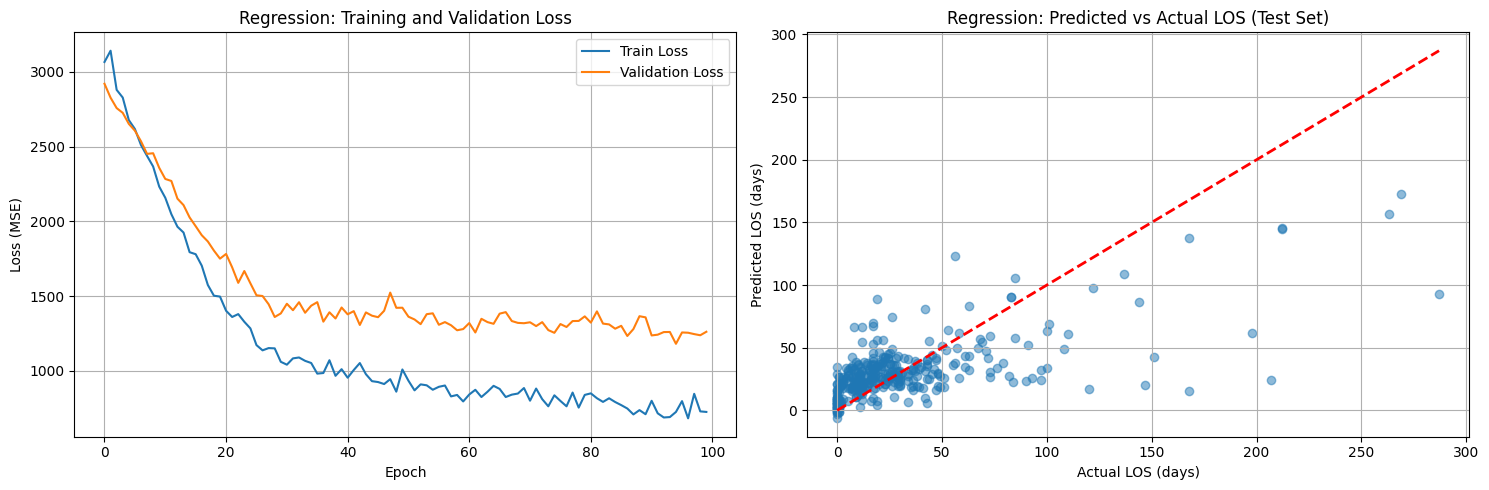


CLASSIFICATION TASKS: Predicting LOS > k days (k=7, 14, 28)

Training Classification Model for LOS > 7 days
Epoch 10/100 - Train Loss: 0.2670, Val Loss: 0.3371
Epoch 20/100 - Train Loss: 0.2133, Val Loss: 0.3605
Early stopping at epoch 22
Saved best model to models/mlp_classifier_k7_weights.pt

Evaluating MLP Classification Model (LOS > 7 days)...

MLP Classification Results (LOS > 7 days):
Train - Acc: 0.6224, Prec: 0.7153, Rec: 0.7863, F1: 0.7492, AUC: 0.4931
Val   - Acc: 0.8846, Prec: 0.8873, Rec: 0.9730, F1: 0.9282, AUC: 0.8463
Test  - Acc: 0.8846, Prec: 0.8913, Rec: 0.9647, F1: 0.9266, AUC: 0.8980
Test Confusion Matrix:
[[ 53  30]
 [  9 246]]

Training Classification Model for LOS > 14 days
Epoch 10/100 - Train Loss: 0.4351, Val Loss: 0.5556
Epoch 20/100 - Train Loss: 0.3962, Val Loss: 0.5287
Epoch 30/100 - Train Loss: 0.3337, Val Loss: 0.5716
Early stopping at epoch 32
Saved best model to models/mlp_classifier_k14_weights.pt

Evaluating MLP Classification Model (LOS > 14 days)..

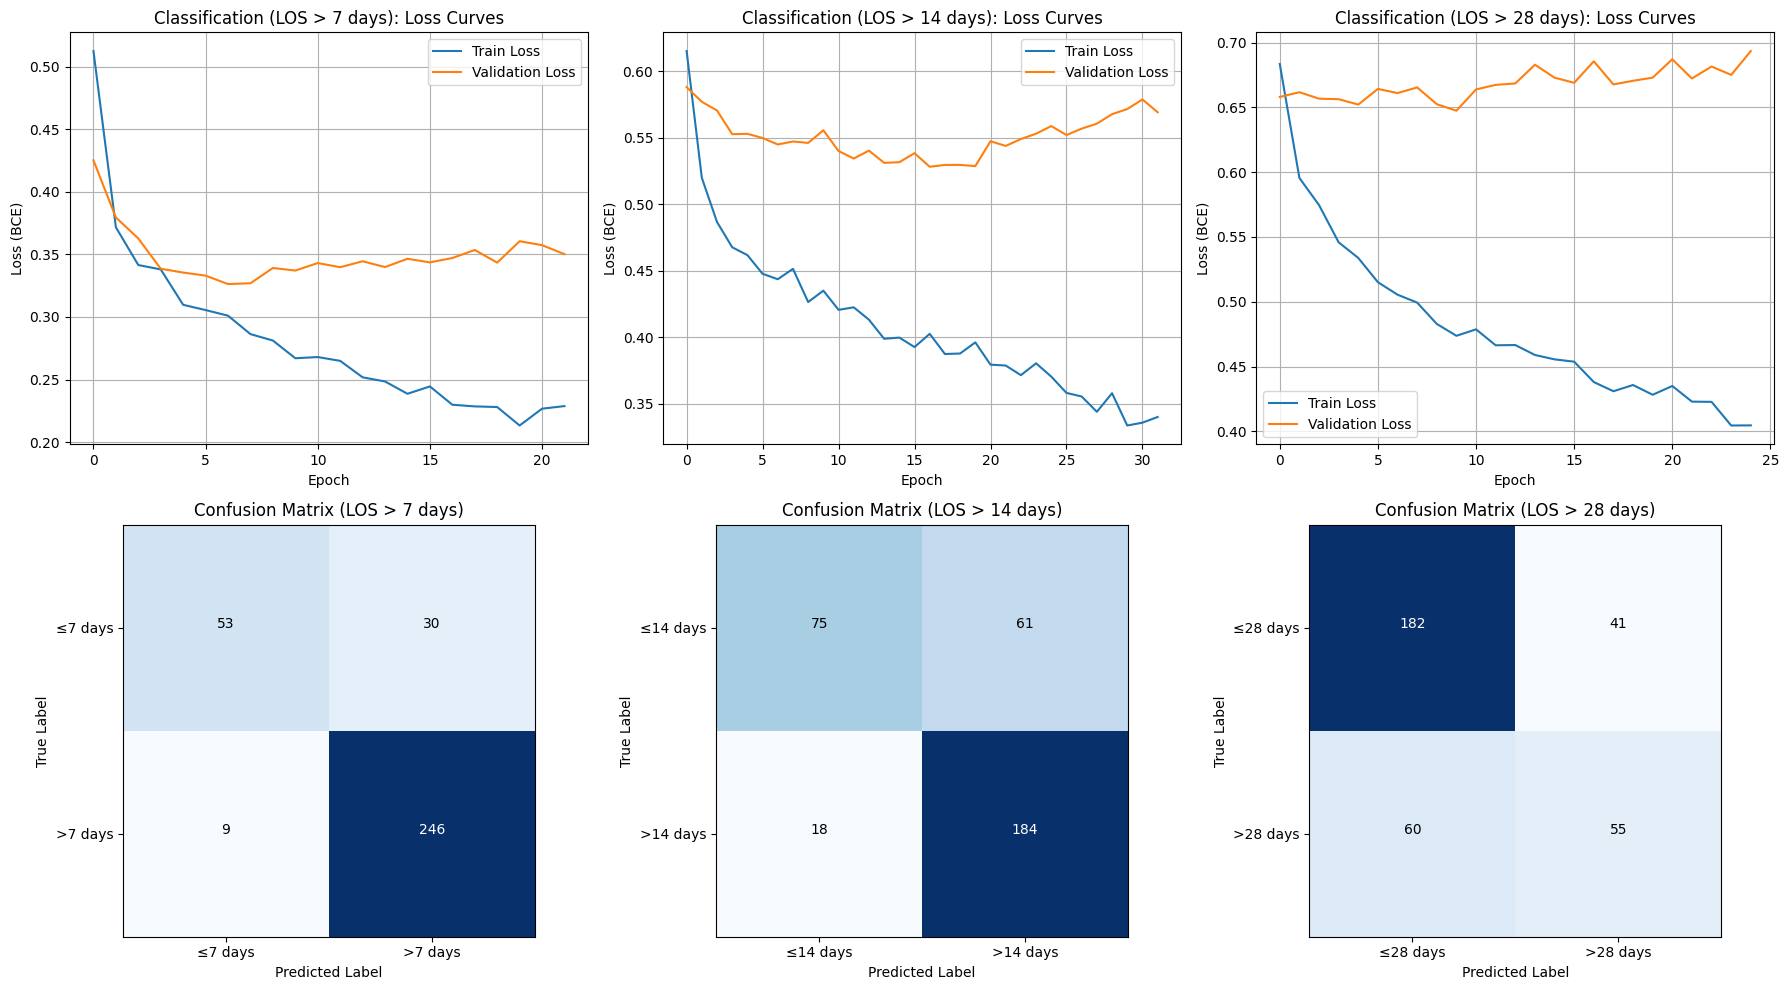


SUMMARY: Classification Performance Comparison
Threshold    Test Accuracy   Test Precision  Test Recall     Test F1         Test AUC       
----------------------------------------------------------------------
LOS >  7 days          0.8846          0.8913          0.9647          0.9266          0.8980
LOS > 14 days          0.7663          0.7510          0.9109          0.8233          0.8263
LOS > 28 days          0.7012          0.5729          0.4783          0.5213          0.7209

All models trained and evaluated successfully!


In [11]:
device = get_device()
print(f"Using device: {device}")

# Load and preprocess data
X_train, X_val, X_test, y_train, y_val, y_test, classification_labels, meta = load_champaign_data_for_mlp_regression(device=device)

BATCH_SIZE = 64

# ===== REGRESSION TASK =====
print("\n" + "="*70)
print("REGRESSION TASK: Predicting continuous LOS")
print("="*70)

train_dataset_reg = TabularDataset(X_train, y_train)
val_dataset_reg = TabularDataset(X_val, y_val)
test_dataset_reg = TabularDataset(X_test)

train_loader_reg = DataLoader(train_dataset_reg, batch_size=BATCH_SIZE, shuffle=True)
val_loader_reg = DataLoader(val_dataset_reg, batch_size=BATCH_SIZE, shuffle=False)
test_loader_reg = DataLoader(test_dataset_reg, batch_size=BATCH_SIZE, shuffle=False)

# Initialize and train MLP regression model
input_dim = meta['input_dim']
mlp_regression = SimpleMLP(input_dim=input_dim, hidden_sizes=[128, 64], dropout=0.3, num_outputs=1)
print("\nTraining MLP Regression Model...")
mlp_regression, train_losses_reg, val_losses_reg = train_mlp_regression(
    mlp_regression, train_loader_reg, val_loader_reg, num_epochs=100, lr=0.001, patience=15, device=device
)

# Evaluate regression model
print("\nEvaluating MLP Regression Model...")
_, train_metrics_reg = evaluate_mlp_regression(mlp_regression, train_loader_reg, device, y_train)
_, val_metrics_reg = evaluate_mlp_regression(mlp_regression, val_loader_reg, device, y_val)
test_predictions_reg, test_metrics_reg = evaluate_mlp_regression(mlp_regression, test_loader_reg, device, y_test)

print("\nMLP Regression Results:")
print(f"Train - MAE: {train_metrics_reg['mae']:.2f}, RMSE: {train_metrics_reg['rmse']:.2f}, R²: {train_metrics_reg['r2']:.4f}")
print(f"Val   - MAE: {val_metrics_reg['mae']:.2f}, RMSE: {val_metrics_reg['rmse']:.2f}, R²: {val_metrics_reg['r2']:.4f}")
print(f"Test  - MAE: {test_metrics_reg['mae']:.2f}, RMSE: {test_metrics_reg['rmse']:.2f}, R²: {test_metrics_reg['r2']:.4f}")

# Plotting regression results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(train_losses_reg, label='Train Loss')
axes[0].plot(val_losses_reg, label='Validation Loss')
axes[0].set_title('Regression: Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True)

axes[1].scatter(y_test, test_predictions_reg, alpha=0.5)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual LOS (days)')
axes[1].set_ylabel('Predicted LOS (days)')
axes[1].set_title('Regression: Predicted vs Actual LOS (Test Set)')
axes[1].grid(True)

plt.tight_layout()
plt.savefig('plots/champaign_mlp_regression_evaluation.png')
plt.show()

# ===== CLASSIFICATION TASKS =====
print("\n" + "="*70)
print("CLASSIFICATION TASKS: Predicting LOS > k days (k=7, 14, 28)")
print("="*70)

classification_results = {}

for k_name, k_val in [('k7', 7), ('k14', 14), ('k28', 28)]:
    print(f"\n{'='*70}")
    print(f"Training Classification Model for LOS > {k_val} days")
    print(f"{'='*70}")
    
    # Get classification labels
    y_train_cls = classification_labels[k_name]['train']
    y_val_cls = classification_labels[k_name]['val']
    y_test_cls = classification_labels[k_name]['test']
    
    # Create datasets
    train_dataset_cls = TabularDataset(X_train, y_train_cls)
    val_dataset_cls = TabularDataset(X_val, y_val_cls)
    test_dataset_cls = TabularDataset(X_test)

    train_loader_cls = DataLoader(train_dataset_cls, batch_size=BATCH_SIZE, shuffle=True)
    val_loader_cls = DataLoader(val_dataset_cls, batch_size=BATCH_SIZE, shuffle=False)
    test_loader_cls = DataLoader(test_dataset_cls, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize and train MLP classification model
    model_path = f'models/mlp_classifier_{k_name}_weights.pt'
    mlp_classifier = SimpleMLP(input_dim=input_dim, hidden_sizes=[128, 64], dropout=0.3, num_outputs=1)
    mlp_classifier, train_losses_cls, val_losses_cls = train_mlp_classification(
        mlp_classifier, train_loader_cls, val_loader_cls, num_epochs=100, lr=0.001, patience=15, device=device, save_path=model_path
    )
    print(f"Saved best model to {model_path}")

    # Evaluate classification model
    print(f"\nEvaluating MLP Classification Model (LOS > {k_val} days)...")
    _, _, train_metrics_cls = evaluate_mlp_classification(mlp_classifier, train_loader_cls, device, y_train_cls)
    _, _, val_metrics_cls = evaluate_mlp_classification(mlp_classifier, val_loader_cls, device, y_val_cls)
    test_predictions_cls, test_probs_cls, test_metrics_cls = evaluate_mlp_classification(mlp_classifier, test_loader_cls, device, y_test_cls)

    print(f"\nMLP Classification Results (LOS > {k_val} days):")
    print(f"Train - Acc: {train_metrics_cls['accuracy']:.4f}, Prec: {train_metrics_cls['precision']:.4f}, "
          f"Rec: {train_metrics_cls['recall']:.4f}, F1: {train_metrics_cls['f1']:.4f}, AUC: {train_metrics_cls['roc_auc']:.4f}")
    print(f"Val   - Acc: {val_metrics_cls['accuracy']:.4f}, Prec: {val_metrics_cls['precision']:.4f}, "
          f"Rec: {val_metrics_cls['recall']:.4f}, F1: {val_metrics_cls['f1']:.4f}, AUC: {val_metrics_cls['roc_auc']:.4f}")
    print(f"Test  - Acc: {test_metrics_cls['accuracy']:.4f}, Prec: {test_metrics_cls['precision']:.4f}, "
          f"Rec: {test_metrics_cls['recall']:.4f}, F1: {test_metrics_cls['f1']:.4f}, AUC: {test_metrics_cls['roc_auc']:.4f}")
    print(f"Test Confusion Matrix:\n{test_metrics_cls['confusion_matrix']}")
    
    classification_results[k_name] = {
        'train': train_metrics_cls,
        'val': val_metrics_cls,
        'test': test_metrics_cls,
        'train_losses': train_losses_cls,
        'val_losses': val_losses_cls
    }

# Plot classification results
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Loss curves for each k
for idx, (k_name, k_val) in enumerate([('k7', 7), ('k14', 14), ('k28', 28)]):
    axes[0, idx].plot(classification_results[k_name]['train_losses'], label='Train Loss')
    axes[0, idx].plot(classification_results[k_name]['val_losses'], label='Validation Loss')
    axes[0, idx].set_title(f'Classification (LOS > {k_val} days): Loss Curves')
    axes[0, idx].set_xlabel('Epoch')
    axes[0, idx].set_ylabel('Loss (BCE)')
    axes[0, idx].legend()
    axes[0, idx].grid(True)

# Confusion matrices
for idx, (k_name, k_val) in enumerate([('k7', 7), ('k14', 14), ('k28', 28)]):
    cm = classification_results[k_name]['test']['confusion_matrix']
    axes[1, idx].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axes[1, idx].set_title(f'Confusion Matrix (LOS > {k_val} days)')
    axes[1, idx].set_ylabel('True Label')
    axes[1, idx].set_xlabel('Predicted Label')
    axes[1, idx].set_xticks([0, 1])
    axes[1, idx].set_yticks([0, 1])
    axes[1, idx].set_xticklabels(['≤{} days'.format(k_val), '>{} days'.format(k_val)])
    axes[1, idx].set_yticklabels(['≤{} days'.format(k_val), '>{} days'.format(k_val)])
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(2):
        for j in range(2):
            axes[1, idx].text(j, i, format(cm[i, j], 'd'),
                            horizontalalignment="center",
                            color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.savefig('plots/champaign_mlp_classification_evaluation.png')
plt.show()

# Summary comparison
print("\n" + "="*70)
print("SUMMARY: Classification Performance Comparison")
print("="*70)
print(f"{'Threshold':<12} {'Test Accuracy':<15} {'Test Precision':<15} {'Test Recall':<15} {'Test F1':<15} {'Test AUC':<15}")
print("-"*70)
for k_name, k_val in [('k7', 7), ('k14', 14), ('k28', 28)]:
    test_metrics = classification_results[k_name]['test']
    print(f"LOS > {k_val:2d} days  {test_metrics['accuracy']:>14.4f}  {test_metrics['precision']:>14.4f}  "
          f"{test_metrics['recall']:>14.4f}  {test_metrics['f1']:>14.4f}  {test_metrics['roc_auc']:>14.4f}")

print("\n" + "="*70)
print("All models trained and evaluated successfully!")
print("="*70)
